In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import torch
import torch
import torch.nn as nn
import torch.optim as optim
with open('../data/data-challenge-student.pickle', 'rb') as handle:
    # dat = pickle.load(handle)
    dat = pd.read_pickle(handle)

In [2]:
X = dat['X_train']
Y = dat['Y']
S = dat['S_train']

In [3]:
# how many ones in S 
print("S ones :",S.sum())
print("S zeros :",S.shape[0] - S.sum())
print("X shape :",X.shape)
print("Y shape :",Y.shape)
print("S shape :",S.shape)

S ones : 12793
S zeros : 14956
X shape : (27749, 768)
Y shape : (27749,)
S shape : (27749,)


In [4]:
# number of classes
print("Y unique :",Y.unique().shape[0])

print("Y value counts :",Y.value_counts())


Y unique : 28
Y value counts : profession_class
21    8285
19    2918
2     2273
18    1715
11    1402
13    1316
22    1295
26    1121
6      994
25     948
1      703
14     542
12     524
20     504
9      499
24     467
0      387
5      386
7      262
4      206
3      184
16     178
15     136
27     115
8      107
17      97
10      93
23      92
Name: count, dtype: int64


In [5]:
print("X head :",X.head())
print("Y head :",Y.head())
print("S head :",S.head())

X head :             0         1         2         3         4         5         6    \
28553 -0.107712  0.202686 -0.036410 -0.538686  0.162234 -0.109034 -0.075343   
6286   0.056359  0.003188 -0.726052 -0.616777  0.064091 -0.068786  0.384864   
36284 -0.331249  0.210670 -0.202662 -0.654994  0.307785 -0.254564 -0.165728   
12083 -0.565799  0.118481  0.185003 -0.692792 -0.056820  0.039130  0.241766   
7859  -0.669160 -0.052143 -0.708578 -0.159049 -0.273591  0.059959 -0.134847   

            7         8         9    ...       758       759       760  \
28553  0.202060 -0.120114 -0.540793  ...  0.058022 -0.117150  0.684212   
6286   0.363644 -0.285173 -0.430806  ... -0.049452 -0.587354 -0.004443   
36284  0.540352 -0.184862 -0.696042  ...  0.069515 -0.030068  0.616826   
12083 -0.113560 -0.138898 -0.768206  ... -0.071413 -0.310701  0.157026   
7859   0.045078 -0.308037 -0.585879  ... -0.018836 -0.473991  0.177165   

            761       762       763       764       765       766      

In [6]:
# dataframe of X
print("X describe :",X.describe())

X describe :                 0             1             2             3             4    \
count  27749.000000  27749.000000  27749.000000  27749.000000  27749.000000   
mean      -0.336415     -0.000947     -0.517365     -0.503902     -0.056925   
std        0.241738      0.248391      0.394988      0.259865      0.260024   
min       -1.650025     -1.140967     -1.930083     -1.560696     -1.098962   
25%       -0.490549     -0.166887     -0.780339     -0.670340     -0.237157   
50%       -0.333451     -0.000796     -0.509399     -0.494708     -0.062312   
75%       -0.176314      0.173093     -0.251268     -0.332255      0.111903   
max        0.643118      1.039149      0.745597      0.514842      1.146440   

                5             6             7             8             9    \
count  27749.000000  27749.000000  27749.000000  27749.000000  27749.000000   
mean      -0.028903      0.214925      0.304056     -0.136354     -0.273534   
std        0.248630      0.252762     

In [7]:
# print features of x correlated with y > 0.9
correlation = X.corrwith(Y)
print("correlation with Y > 0.5 :",correlation[correlation > 0.5])



correlation with Y > 0.5 : Series([], dtype: float64)


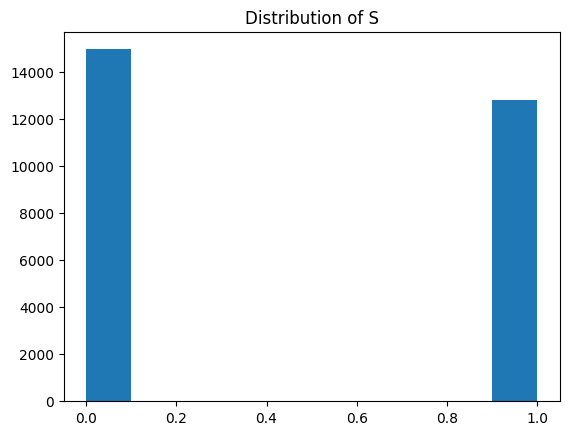

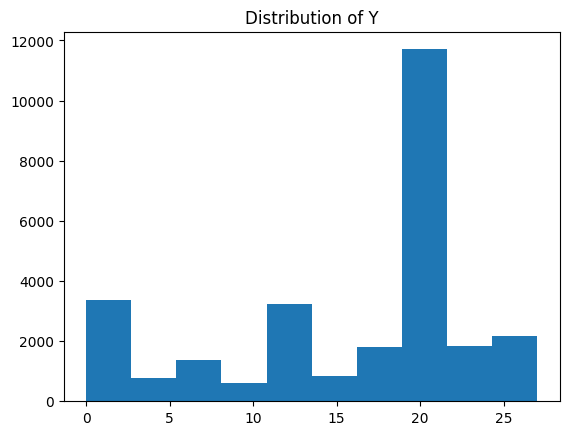

In [8]:
# visualize distribution of data
plt.hist(S)
plt.title('Distribution of S')
plt.show()

# visualize distribution of data
plt.hist(Y)
plt.title('Distribution of Y')
plt.show()

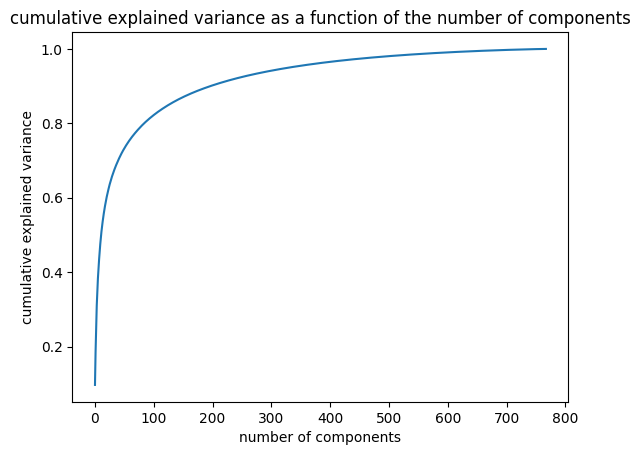

In [9]:
# Feature selection with pca
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X)
# cumulative explained variance
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()
plt.plot(cumulative_explained_variance)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('cumulative explained variance as a function of the number of components')
plt.show()

In [10]:
# chose components that explain 95% of the variance
pca = PCA(n_components=0.95)
pca.fit(X)
X_pca = pca.transform(X)
# transform to tensor
X_pca = torch.tensor(X_pca)
print(Y.shape)
print("X_pca shape :",X_pca.shape)

(27749,)
X_pca shape : torch.Size([27749, 332])


In [18]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.MLP = nn.Sequential(
            nn.Linear(332, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 28),
            nn.Softmax()
        )

    def forward(self, x):
        logits = self.MLP(x)
        return logits

loss_fn = nn.CrossEntropyLoss()

# Create an instance of the neural network
model = NeuralNetwork().to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train(model, optimizer, loss_fn, inputs, labels):
    model.train()
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

# Example usage
inputs = X_pca.to(device)
Y = torch.tensor(Y)
labels = Y.to(device)
loss = train(model, optimizer, loss_fn, inputs, labels)
print("Loss:", loss)

KeyError: 1